In [1]:
import numpy as np
import ufl

from petsc4py import PETSc
from mpi4py import MPI
from dolfinx import fem, mesh, plot
L = 20.0
domain = mesh.create_box(MPI.COMM_WORLD,[[0.0,0.0,0.0], [L, 1, 1]], [20, 5, 5], mesh.CellType.hexahedron)
V = fem.VectorFunctionSpace(domain, ("CG", 2))

In [2]:
def left(x):
    return np.isclose(x[0], 0)

def right(x):
    return np.isclose(x[0], L)

fdim = domain.topology.dim -1
left_facets = mesh.locate_entities_boundary(domain, fdim, left)
right_facets = mesh.locate_entities_boundary(domain, fdim, right)

In [3]:
# Concatenate and sort the arrays based on facet indices. Left facets marked with 1, right facets with two
marked_facets = np.hstack([left_facets, right_facets])
marked_values = np.hstack([np.full_like(left_facets, 1), np.full_like(right_facets, 2)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

In [4]:
u_bc = np.array((0,) * domain.geometry.dim, dtype=PETSc.ScalarType)

In [5]:
left_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(1))
bcs = [fem.dirichletbc(u_bc, left_dofs, V)]

In [6]:
B = fem.Constant(domain, PETSc.ScalarType((0, 0, 0)))
T = fem.Constant(domain, PETSc.ScalarType((0, 0, 0)))

In [7]:
v = ufl.TestFunction(V)
u = fem.Function(V)

In [8]:
# Spatial dimension
d = len(u)

# Identity tensor
I = ufl.variable(ufl.Identity(d))

# Deformation gradient
F = ufl.variable(I + ufl.grad(u))

# Right Cauchy-Green tensor
C = ufl.variable(F.T * F)

# Invariants of deformation tensors
Ic = ufl.variable(ufl.tr(C))
J  = ufl.variable(ufl.det(F))

In [9]:
# Elasticity parameters
E = PETSc.ScalarType(1.0e4)
nu = PETSc.ScalarType(0.3)
mu = fem.Constant(domain, E/(2*(1 + nu)))
lmbda = fem.Constant(domain, E*nu/((1 + nu)*(1 - 2*nu)))
# Stored strain energy density (compressible neo-Hookean model)
psi = (mu / 2) * (Ic - 3) - mu * ufl.ln(J) + (lmbda / 2) * (ufl.ln(J))**2
# Stress
# Hyper-elasticity
P = ufl.diff(psi, F)

In [10]:
metadata = {"quadrature_degree": 4}
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag, metadata=metadata)
dx = ufl.Measure("dx", domain=domain, metadata=metadata)
# Define form F (we want to find u such that F(u) = 0)
F = ufl.inner(ufl.grad(v), P)*dx - ufl.inner(v, B)*dx - ufl.inner(v, T)*ds(2) 

In [11]:
problem = fem.petsc.NonlinearProblem(F, u, bcs)

In [12]:
from dolfinx import nls
solver = nls.petsc.NewtonSolver(domain.comm, problem)

# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

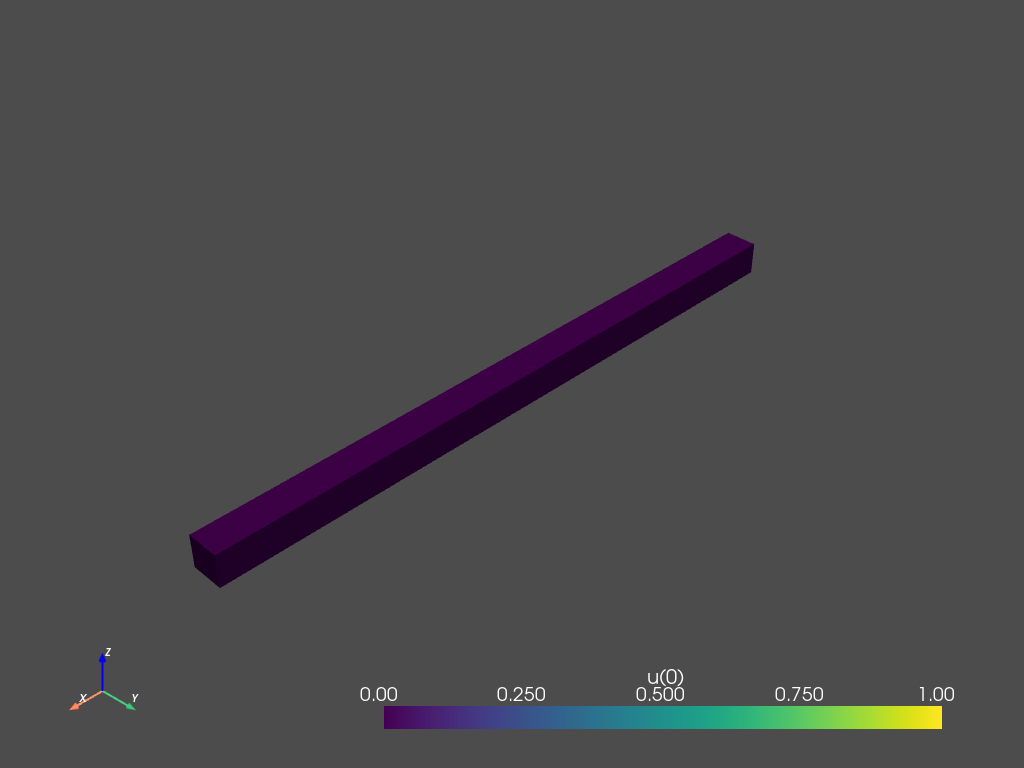

In [14]:
import pyvista
pyvista.set_jupyter_backend("none")

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(domain, domain.topology.dim))

def plot_function(t, uh):
    """
    Create a figure of the concentration uh warped visualized in 3D at timet step t.
    """
    p = pyvista.Plotter()
    # Create grid defined by the function space for visualization of the function
    topology, cells, geometry = plot.create_vtk_mesh(uh.function_space)
    function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)
    var_name = f"u({t})"
    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(uh)] = uh.x.array.reshape(geometry.shape[0], len(uh))
    function_grid[var_name] = values
    function_grid.set_active_vectors(var_name)
    # Warp mesh by deformation
    warped = function_grid.warp_by_vector(var_name, factor=1)
    
    # Add mesh to plotter and visualize
    actor = p.add_mesh(warped)
    p.show_axes()
    if not pyvista.OFF_SCREEN:
       p.show()
    else:
        pyvista.start_xvfb()
        figure_as_array = p.screenshot(f"diffusion_{t:.2f}.png")
        # Clear plotter for next plot
        p.remove_actor(actor)

plot_function(0, u)

2022-10-31 19:28:51.560 ( 240.339s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:28:53.270 ( 242.049s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:28:54.145 ( 242.924s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 22.2455 (tol = 1e-08) r (rel) = 0.134278(tol = 1e-08)
2022-10-31 19:28:54.425 ( 243.204s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:28:55.229 ( 244.008s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 2.43261 (tol = 1e-08) r (rel) = 0.0146837(tol = 1e-08)
2022-10-31 19:28:55.511 ( 244.290s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:28:56.782 ( 245.561s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 

Time step 1, Number of iterations 8, Load [ 0.   0.  -1.5]


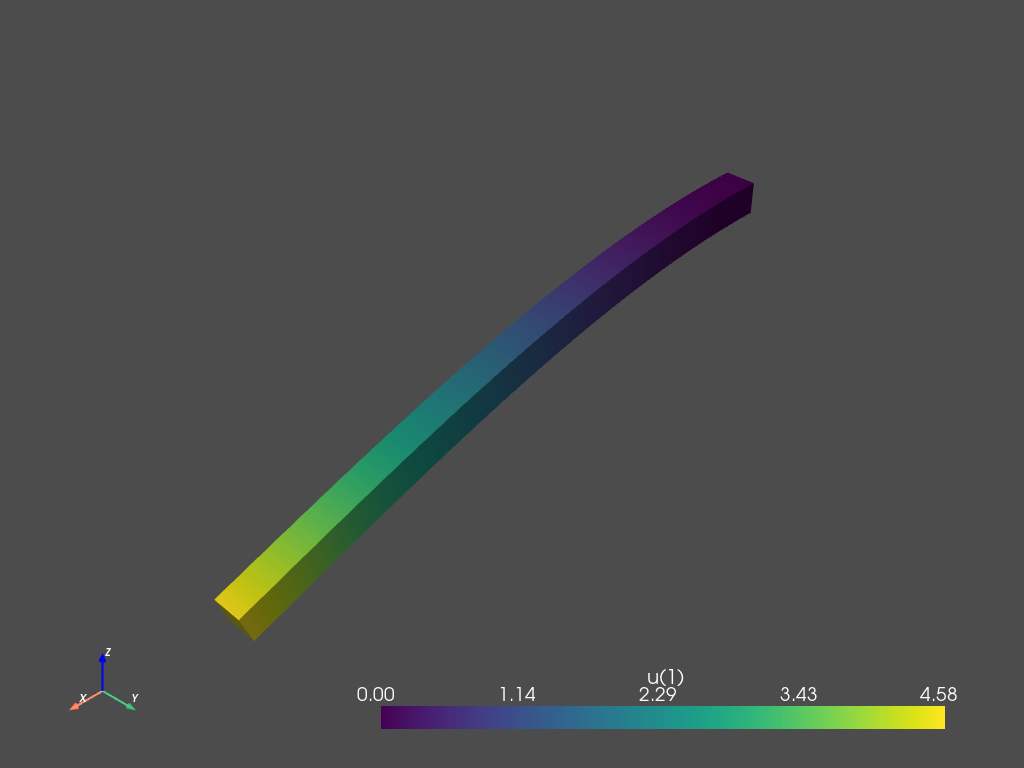

2022-10-31 19:29:02.804 ( 251.583s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:04.126 ( 252.905s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:05.168 ( 253.947s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 17.3254 (tol = 1e-08) r (rel) = 0.117842(tol = 1e-08)
2022-10-31 19:29:05.485 ( 254.264s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:06.440 ( 255.219s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 5.14882 (tol = 1e-08) r (rel) = 0.0350207(tol = 1e-08)
2022-10-31 19:29:06.734 ( 255.513s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:07.601 ( 256.380s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 

Time step 2, Number of iterations 9, Load [ 0.  0. -3.]


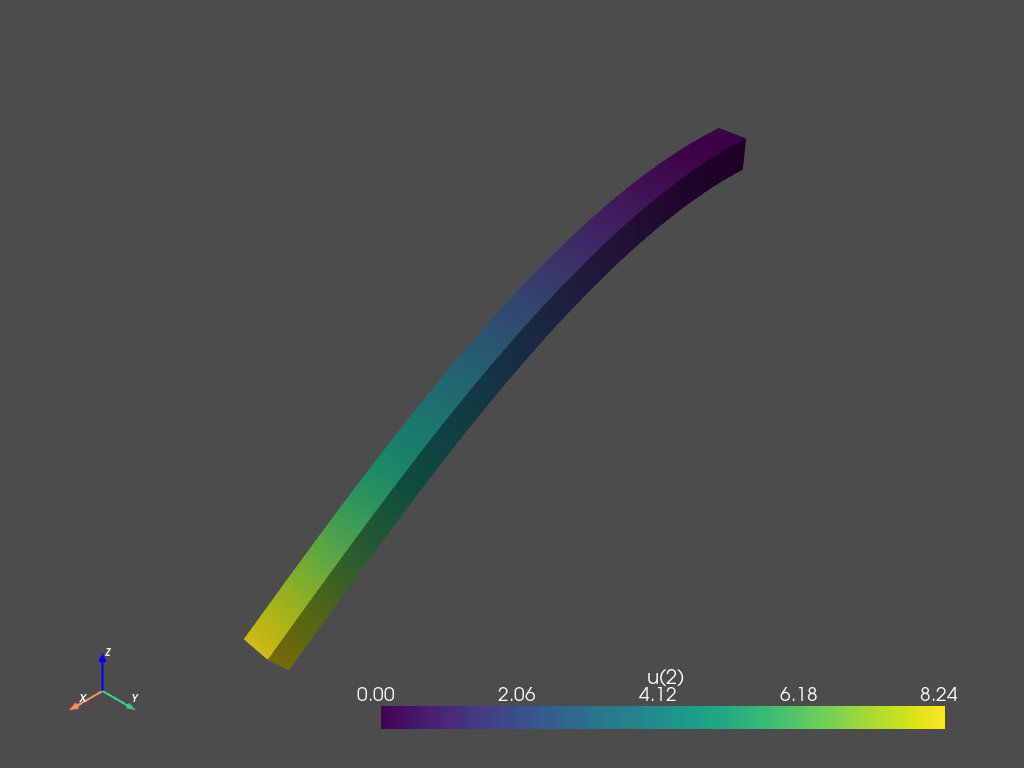

2022-10-31 19:29:21.567 ( 270.346s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:24.283 ( 273.062s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:26.617 ( 275.396s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 10.0011 (tol = 1e-08) r (rel) = 0.0887471(tol = 1e-08)
2022-10-31 19:29:27.035 ( 275.814s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:29.853 ( 278.632s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 5.33026 (tol = 1e-08) r (rel) = 0.0472992(tol = 1e-08)
2022-10-31 19:29:30.228 ( 279.008s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:32.603 ( 281.382s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration

Time step 3, Number of iterations 10, Load [ 0.   0.  -4.5]


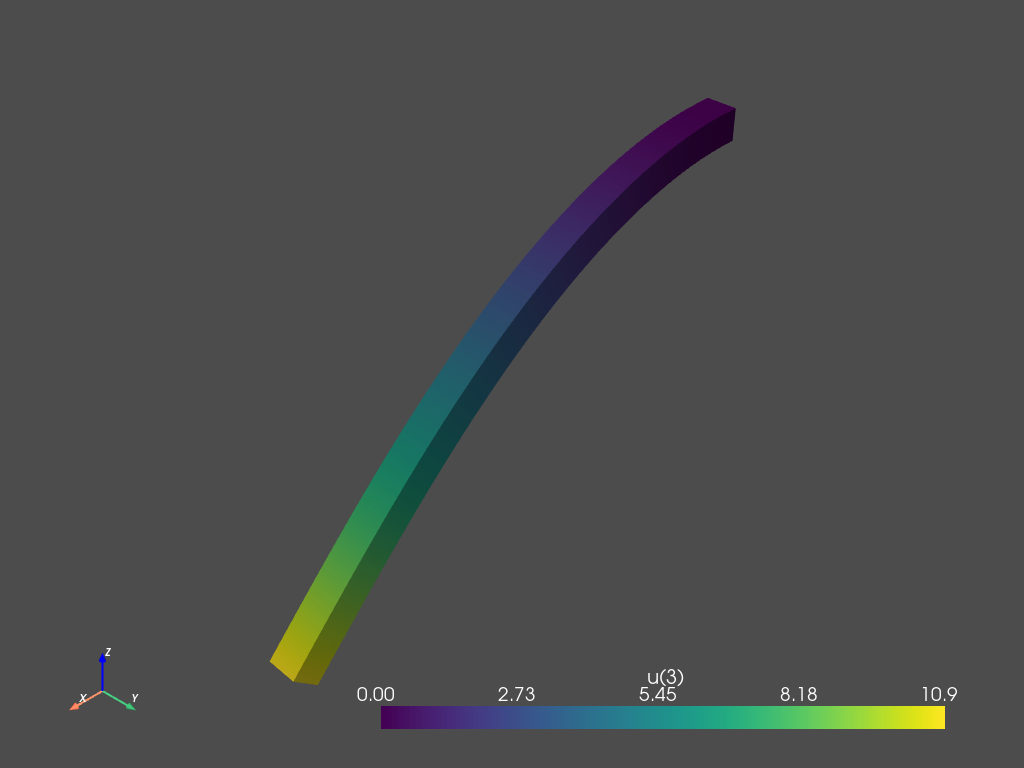

2022-10-31 19:29:45.676 ( 294.455s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:47.197 ( 295.976s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:48.305 ( 297.084s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 5.50693 (tol = 1e-08) r (rel) = 0.0653918(tol = 1e-08)
2022-10-31 19:29:48.585 ( 297.364s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:49.493 ( 298.272s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 26.2489 (tol = 1e-08) r (rel) = 0.311692(tol = 1e-08)
2022-10-31 19:29:49.771 ( 298.551s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:50.605 ( 299.384s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 

Time step 4, Number of iterations 9, Load [ 0.  0. -6.]


2022-10-31 19:29:56.504 ( 305.283s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 9: r (abs) = 2.63797e-07 (tol = 1e-08) r (rel) = 3.13244e-09(tol = 1e-08)
2022-10-31 19:29:56.504 ( 305.283s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 9 iterations and 9 linear solver iterations.


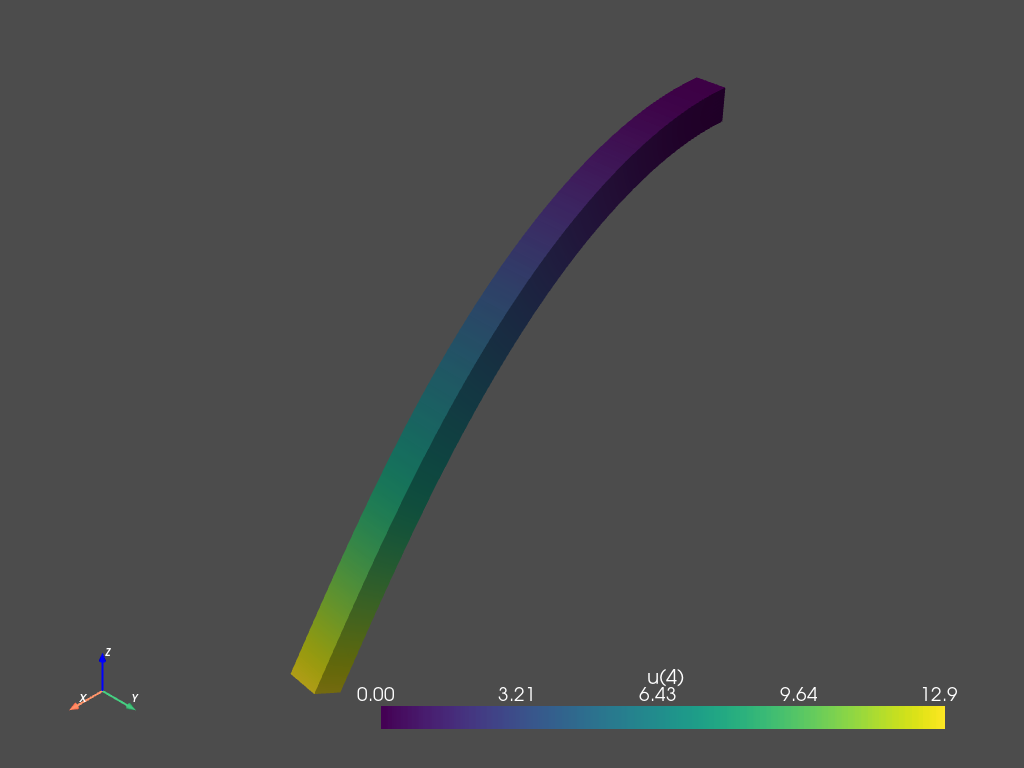

2022-10-31 19:29:56.973 ( 305.752s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:58.482 ( 307.261s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:29:59.325 ( 308.105s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 3.19462 (tol = 1e-08) r (rel) = 0.0496479(tol = 1e-08)
2022-10-31 19:29:59.607 ( 308.387s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:00.477 ( 309.256s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 7.71429 (tol = 1e-08) r (rel) = 0.119888(tol = 1e-08)
2022-10-31 19:30:00.755 ( 309.535s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:01.682 ( 310.461s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 

Time step 5, Number of iterations 8, Load [ 0.   0.  -7.5]


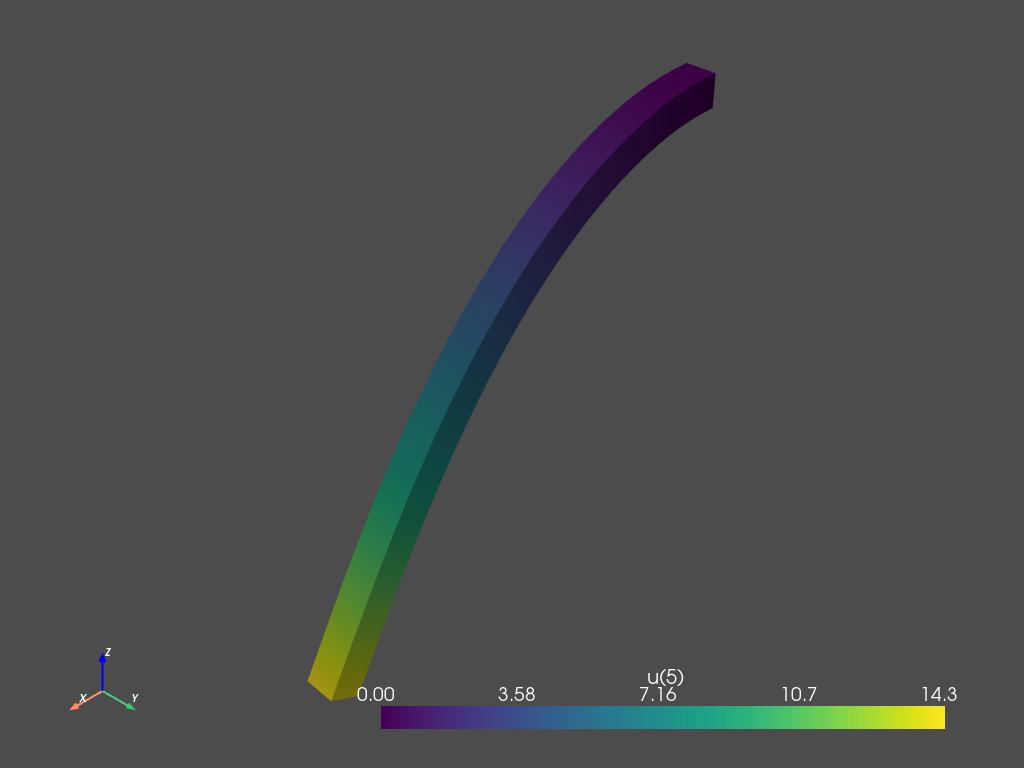

2022-10-31 19:30:06.570 ( 315.349s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:07.768 ( 316.547s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:08.777 ( 317.556s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 2.00649 (tol = 1e-08) r (rel) = 0.0395622(tol = 1e-08)
2022-10-31 19:30:09.088 ( 317.867s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:09.851 ( 318.630s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 4.60977 (tol = 1e-08) r (rel) = 0.0908914(tol = 1e-08)
2022-10-31 19:30:10.136 ( 318.915s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:10.960 ( 319.739s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration

Time step 6, Number of iterations 7, Load [ 0.  0. -9.]


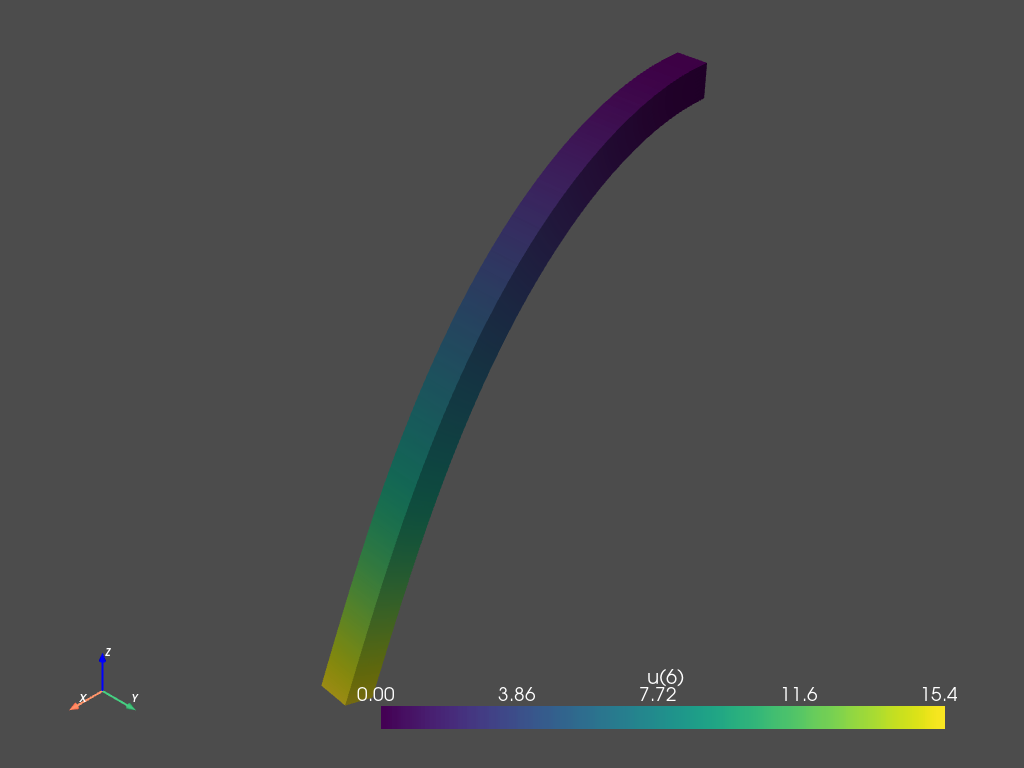

2022-10-31 19:30:14.767 ( 323.546s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:16.083 ( 324.863s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:16.851 ( 325.630s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.38506 (tol = 1e-08) r (rel) = 0.0336622(tol = 1e-08)
2022-10-31 19:30:17.153 ( 325.932s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:18.180 ( 326.959s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 3.03739 (tol = 1e-08) r (rel) = 0.07382(tol = 1e-08)
2022-10-31 19:30:18.487 ( 327.266s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:19.677 ( 328.457s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 4

Time step 7, Number of iterations 6, Load [  0.    0.  -10.5]


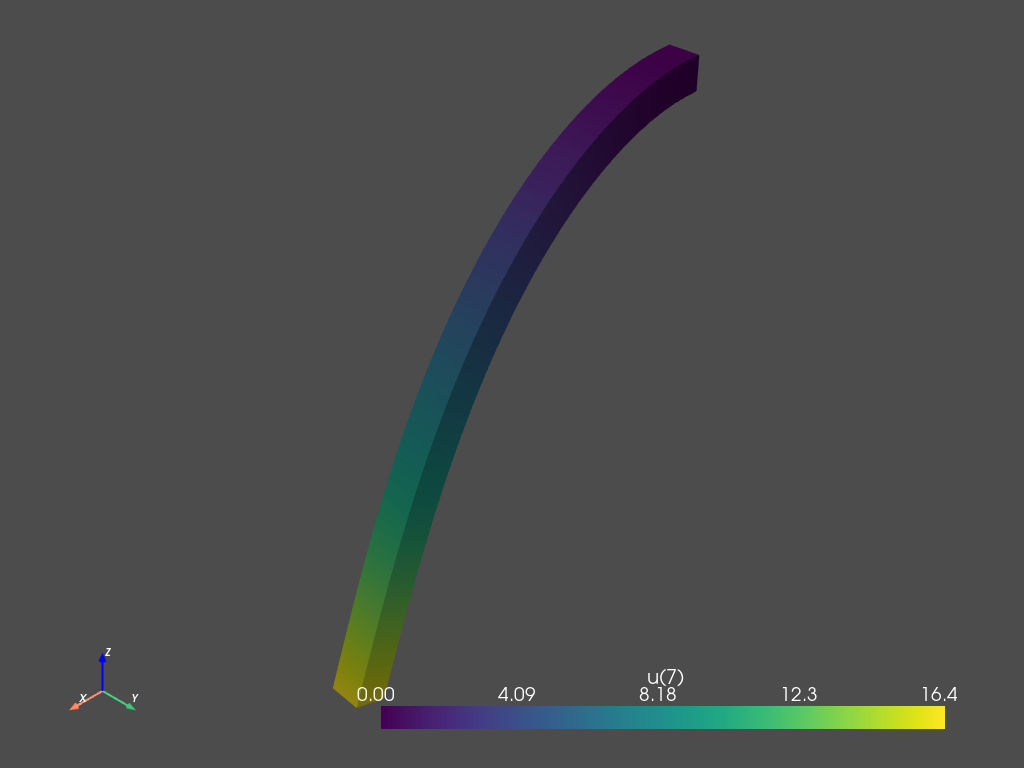

2022-10-31 19:30:22.955 ( 331.734s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:25.915 ( 334.694s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:28.683 ( 337.462s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 1.06336 (tol = 1e-08) r (rel) = 0.031085(tol = 1e-08)
2022-10-31 19:30:29.074 ( 337.853s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:31.724 ( 340.503s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 2.0477 (tol = 1e-08) r (rel) = 0.0598598(tol = 1e-08)
2022-10-31 19:30:32.103 ( 340.882s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:33.771 ( 342.551s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 4

Time step 8, Number of iterations 6, Load [  0.   0. -12.]


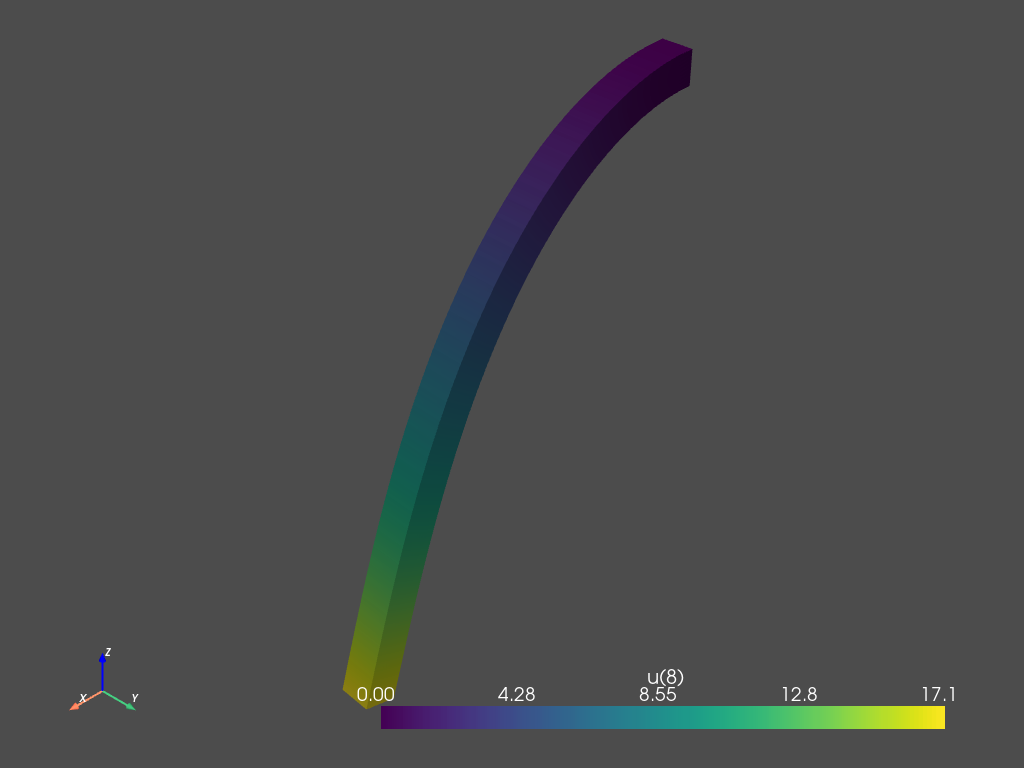

2022-10-31 19:30:37.323 ( 346.102s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:38.518 ( 347.297s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:39.452 ( 348.231s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 0.898789 (tol = 1e-08) r (rel) = 0.0309666(tol = 1e-08)
2022-10-31 19:30:39.732 ( 348.511s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:40.672 ( 349.451s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 1.38354 (tol = 1e-08) r (rel) = 0.0476679(tol = 1e-08)
2022-10-31 19:30:40.955 ( 349.734s) [main            ]              petsc.cpp:677   INFO| PETSc Krylov solver starting to solve system.
2022-10-31 19:30:41.816 ( 350.595s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteratio

Time step 9, Number of iterations 6, Load [  0.    0.  -13.5]


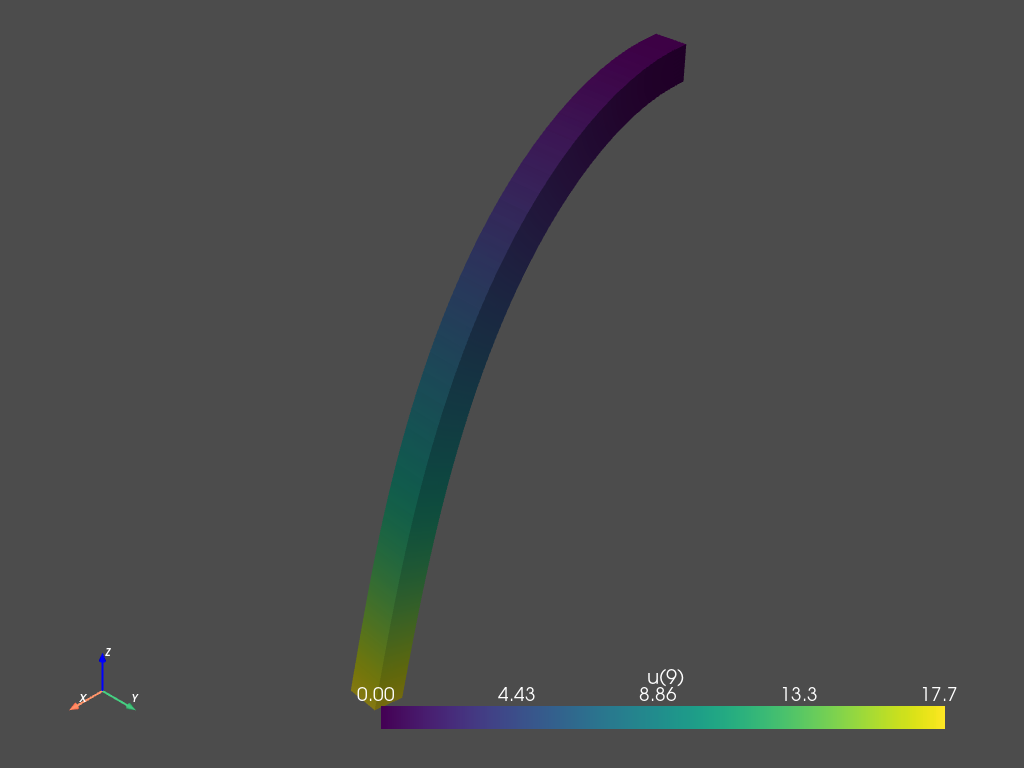

In [15]:
from dolfinx import log
log.set_log_level(log.LogLevel.INFO)
tval0 = -1.5
for n in range(1, 10):
    T.value[2] = n * tval0
    num_its, converged = solver.solve(u)
    assert(converged)
    u.x.scatter_forward()
    print(f"Time step {n}, Number of iterations {num_its}, Load {T.value}")
    plot_function(n, u)